In [2]:
%run setup_PS_data_multi.ipynb
import pandas as pd
from tqdm import tqdm
print('------------------------------------')
print(f'{len(sessions)} sessions are loaded')

ERROR:root:File `'setup_notebook.ipynb.py'` not found.


Now loading mouse J048, run 27
microcontroller trial starts occur on average -36.39 ms from galvo trial starts
number of pre frames: 20, number of post frames 30
Shape new array : (2101, 143, 50)
(2101, 143, 50) (2101, 8, 40)
photo stim occurences: {0: 51, 1: 51, 2: 41}
Occurence table:
[[26. 25.]
 [25. 26.]
 [ 5. 36.]]
130 / 130 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]
Time array: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
Now loading mouse J048, run 30
microcontroller trial starts occur on average -37.0 ms from galvo trial starts
number of pre frames: 20, number of post frames 30
Shape new array : (2085, 235, 50)
(2085, 235, 50) (2085, 8, 40)
photo stim occurences: {0: 88, 1: 84, 2: 63}
Occurence table:
[[56. 32.]
 [31. 53.]
 [ 9. 54.]]
209 / 209 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]
Time array: [ 0  1  2 

# START

In [3]:
  # determine regularizer param with CV on training data
  #NB: have not tried to implement this yet
  # train /test  folds

def fun_return_2d(data):  # possibly add fancy stuff
    return np.mean(data, 2)


In [37]:
def train_test_all_sessions(trial_times_use=None, verbose=2, list_test = ['dec', 'stim'],
                            hitmiss_only=False, cv_regularizer = False, include_150 = False,
                            n_split = 4, include_autoreward=True, neurons_selection='all'):
    if verbose >= 1:
        if hitmiss_only:
            print('Using hit/miss trials only.')
    name_list = ['autorewarded']
    for nn in list_test:
        name_list.append('pred_' + nn)
    for nn in ['dec', 'stim']:
        name_list.append('true_' + nn)
    dict_predictions_test = {x + '_test': np.array([]) for x in name_list}
    dict_predictions_train = {x + '_train': np.array([]) for x in name_list}

    for i_session, session in sessions.items():
        if verbose >= 1:
            print(f'Starting loop {i_session + 1}/{len(sessions)}')
        if trial_times_use is None:
            trial_times_use = session.filter_ps_array[(session.final_pre_gap_tp + 1):(session.final_pre_gap_tp + 6)]
        n_trial_times_used = len(trial_times_use)

        if neurons_selection == 'all':
            neurons_include = np.arange(session.behaviour_trials.shape[0])
        elif neurons_selection == 's1':
            neurons_include = session.s1_bool
        elif neurons_selection == 's2':
            neurons_include = session.s2_bool
            
        if include_150 is False:
            trial_inds = np.where(session.photostim < 2)[0]
        else:
            trial_inds = np.arange(len(session.photostim))
        
        if hitmiss_only:
            hitmiss_trials = np.where(np.logical_or(sessions[0].outcome == 'hit', sessions[0].outcome == 'miss'))[0]
            if verbose == 2:
                print(f'Size hm {hitmiss_trials.size}, trial inds {trial_inds.size}')
            trial_inds = np.intersect1d(trial_inds, hitmiss_trials)
            
        if include_autoreward is False:
            ar_exclude = np.where(session.autorewarded == False)[0]
            if verbose == 2:
                print(f'{np.sum(sessions.autorewarded)} autorewarded trials found and excluded')
            trial_inds = np.intersect1d(trial_inds, ar_exclude)
                      
        if verbose == 2:
            print(f'final size {trial_inds.size}')
        n_trials = len(trial_inds)
        
        if verbose == 2:
            print(f'Total number of trials is {n_trials}. Number of splits is {n_split}')

        data_use = session.behaviour_trials[neurons_include, :, :]
        data_use = data_use[:, :, trial_times_use]
        data_use = data_use[:, trial_inds, :]
        data_use = fun_return_2d(data_use)
        stand_scale = sklearn.preprocessing.StandardScaler()
        data_use = stand_scale.fit_transform(data_use)

        sss = sklearn.model_selection.StratifiedKFold(n_splits=n_split)
        if verbose == 2:
            print(f'Number of licks: {np.sum(session.decision[trial_inds])}')
        i_loop = 0
        for train_inds, test_inds in sss.split(X=np.zeros(n_trials), y=session.photostim[trial_inds]):
            train_data, test_data = data_use[:, train_inds], data_use[:, test_inds]
            if i_loop == 0:
                if verbose == 2:
                    print(f'Shape train data {train_data.shape}, test data {test_data.shape}')

            train_labels = {'stim': session.photostim[trial_inds[train_inds]],
                            'dec': session.decision[trial_inds[train_inds]]}
            test_labels = {'stim': session.photostim[trial_inds[test_inds]], 
                           'dec': session.decision[trial_inds[test_inds]]}
            if verbose == 2:
                print(f' Number of test licks {np.sum(test_labels["dec"])}')
            detailed_ps_labels = session.trial_subsets[trial_inds]
            autorewarded = session.autorewarded[trial_inds]
            assert len(train_labels['dec']) == train_data.shape[1]
            assert len(test_labels['stim']) == test_data.shape[1]

            ## Train logistic regression model
            dec = {}
            if cv_regularizer:
                reg_array = {'C': np.logspace(-3, 0, 20), 'class_weight': 'balanced'}
                for x in list_test:
                    grid = sklearn.model_selection.GridSearchCV(sklearn.linear_model.LogisticRegression(),
                                                                reg_array, cv=5)
                    grid.fit(X=train_data.transpose(), y=train_labels[x])
                    if verbose == 2:
                        print(grid.best_params_)
                    dec[x] = sklearn.linear_model.LogisticRegression(C=grid.best_params_['C'],
                                                         class_weight='balanced').fit(
                            X=train_data.transpose(), y=train_labels[x])
            else:
                for x in list_test:
                    dec[x] = sklearn.linear_model.LogisticRegression(C=0.2, class_weight='balanced').fit(
                                    X=train_data.transpose(), y=train_labels[x])

            pred_proba_train = {x: dec[x].predict_proba(X=train_data.transpose())[:, 1] for x in list_test}
            pred_proba_test = {x: dec[x].predict_proba(X=test_data.transpose())[:, 1] for x in list_test}

            for x in list_test:
                dict_predictions_train[f'pred_{x}_train'] = np.concatenate((dict_predictions_train[f'pred_{x}_train'], pred_proba_train[x]))
                dict_predictions_test[f'pred_{x}_test'] = np.concatenate((dict_predictions_test[f'pred_{x}_test'], pred_proba_test[x]))
#             if 'stim' in list_test:
            dict_predictions_train['true_stim_train'] = np.concatenate((dict_predictions_train['true_stim_train'], detailed_ps_labels[train_inds]))
            dict_predictions_test['true_stim_test'] = np.concatenate((dict_predictions_test['true_stim_test'], detailed_ps_labels[test_inds]))
            dict_predictions_train['autorewarded_train'] = np.concatenate((dict_predictions_train['autorewarded_train'], autorewarded[train_inds]))
            dict_predictions_test['autorewarded_test'] = np.concatenate((dict_predictions_test['autorewarded_test'], autorewarded[test_inds]))
            dict_predictions_train['true_dec_train'] = np.concatenate((dict_predictions_train['true_dec_train'], train_labels['dec']))
            dict_predictions_test['true_dec_test'] = np.concatenate((dict_predictions_test['true_dec_test'], test_labels['dec']))
            i_loop += 1
    if verbose == 2:
        print(f'length test: {len(dict_predictions_test["true_dec_test"])}')
        
    df_prediction_train = pd.DataFrame(dict_predictions_train)
    df_prediction_test = pd.DataFrame(dict_predictions_test)
    
    return df_prediction_train, df_prediction_test

Starting loop 1/3
Starting loop 2/3
Starting loop 3/3


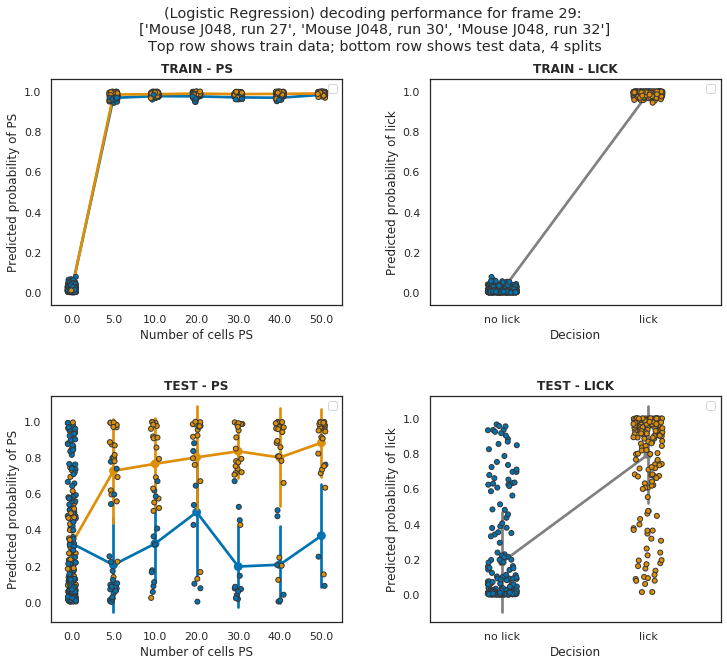

In [42]:
time_frame = 29
n_splits = 4

df_prediction_train, df_prediction_test = train_test_all_sessions(verbose=1, n_split=n_splits,
                                              trial_times_use=np.array([time_frame]),
                                         hitmiss_only=False, list_test=['dec', 'stim'],
                                         include_autoreward=False, neurons_selection='s2')

plt.rcParams['figure.figsize'] = (12, 10)
plt.subplots_adjust(wspace=0.3, hspace=0.4)

def plot_df_stats(df, xx, yy, hh, plot_line=True, xticklabels=None):
    if plot_line and hh is None:
        sns.pointplot(data=df, x=xx, y=yy, color='grey', ci='sd')
    elif plot_line and hh is not None:
        sns.pointplot(data=df, x=xx, y=yy, hue=hh, ci='sd')
#     elif plot_line and hh is not None:
        
    tmp = sns.stripplot(x=xx, y=yy, hue=hh, data=df, linewidth=1)
    if xticklabels is not None:
        tmp.set_xticklabels(xticklabels)
    
## NB: To not plot with hue, set hh=None
if 'pred_stim_train' in df_prediction_train.columns:
    plt.subplot(221)
    plot_df_stats(df=df_prediction_train, xx='true_stim_train', yy='pred_stim_train', hh='true_dec_train')  # set hh=None or hh='dec_train'
    plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TRAIN - PS', weight='bold')
    plt.legend([])
    
    plt.subplot(223)
    plot_df_stats(df=df_prediction_test, xx='true_stim_test', yy='pred_stim_test', hh='true_dec_test')  # set hh=None or hh='dec_test'
    plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TEST - PS', weight='bold')
    plt.legend([])

if 'pred_dec_train' in df_prediction_train.columns:  
    plt.subplot(222)
    plot_df_stats(df=df_prediction_train, xx='true_dec_train', yy='pred_dec_train', hh=None, xticklabels=['no lick', 'lick'])
    plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TRAIN - LICK', weight='bold')
    plt.legend('No lick', 'lick')
    
    plt.subplot(224)
    plot_df_stats(df=df_prediction_test, xx='true_dec_test', yy='pred_dec_test', hh=None, xticklabels=['no lick', 'lick'])
    plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TEST - LICK', weight='bold');
    plt.legend([])
plt.suptitle(f'(Logistic Regression) decoding performance for frame {time_frame}: \n{[str(sessions[x]) for x in range(len(sessions))]}\n' + 
#              f'Left column shows Photostimulation (PS) decoding performance, right column shows lick decoding\n' +
             f'Top row shows train data; bottom row shows test data, {n_splits} splits\n');

## Dynamic coding:

In [33]:
n_timepoints = len(sessions[0].filter_ps_array)
cv_regularizer = False
lick_acc = np.zeros(n_timepoints)
lick_acc_split = {x: np.zeros(n_timepoints) for x in df_prediction_test['true_stim_test'].unique()}
if 'pred_stim_test' in df_prediction_test.columns:
    ps_acc = np.zeros(n_timepoints)
    ps_acc_split = {x: np.zeros(n_timepoints) for x in df_prediction_test['true_dec_test'].unique()}
    
def mean_accuracy(binary_truth, estimate):
    assert len(binary_truth) == len(estimate)
    return np.mean(binary_truth * estimate + (1 - binary_truth) * (1 - estimate))

for i_tp, tp in tqdm(enumerate(sessions[0].filter_ps_array)):
    df_prediction_train, df_prediction_test = train_test_all_sessions(trial_times_use=np.array([tp]), 
                                                                      verbose=0, 
                                                                     include_autoreward=True)
    lick = df_prediction_test['true_dec_test']
    ps = (df_prediction_test['true_stim_test'] > 0).astype('int')
    pred_lick = df_prediction_test['pred_dec_test']
    
    lick_acc[i_tp] = mean_accuracy(binary_truth=lick, estimate=pred_lick)
    for x, arr in lick_acc_split.items():
        arr[i_tp] = mean_accuracy(binary_truth=lick[np.where(df_prediction_test['true_stim_test'] == x)[0]], 
                                  estimate=pred_lick[np.where(df_prediction_test['true_stim_test'] == x)[0]])
    
    if 'pred_stim_test' in df_prediction_test.columns:
        pred_ps = df_prediction_test['pred_stim_test']
        ps_acc[i_tp] = mean_accuracy(binary_truth=ps, estimate=pred_ps)
        for x, arr in ps_acc_split.items():
            arr[i_tp] = mean_accuracy(binary_truth=ps[np.where(lick == x)[0]], 
                                      estimate=pred_ps[np.where(lick == x)[0]])

46it [00:39,  1.18it/s]


In [28]:
# lick_acc_split

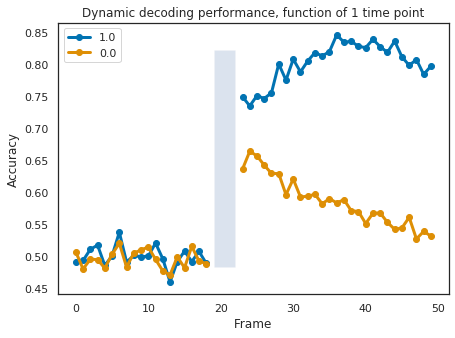

In [32]:
plt.rcParams['figure.figsize'] = (7, 5)
ax_acc = plt.subplot(111)

color_dict_stand = {}
for ii, x in enumerate(plt.rcParams['axes.prop_cycle']()):
    color_dict_stand[ii] = x['color']
    if ii > 8:
        break
        
def plot_interrupted_trace(ax, plot_array, llabel='', linest='-', ccolor='grey'):
    breakpoint = sessions[0].art_gap_start
    time_1 = sessions[0].filter_ps_array[:breakpoint]
    time_2 = sessions[0].filter_ps_array[breakpoint:]
    
    ax_acc.plot(time_1, plot_array[:breakpoint], '.-', linewidth=3, linestyle=linest, markersize=12, color=ccolor, label=llabel)
    ax_acc.plot(time_2, plot_array[breakpoint:], '.-', linewidth=3, linestyle=linest, markersize=12, color=ccolor)
    ax_acc.axvspan(xmin=time_1[-1] + 1, xmax=time_2[0] - 1, ymin=0.1, ymax=0.9, alpha=0.1)
    return ax_acc

# plot_interrupted_trace(ax=ax_acc, plot_array=lick_acc, llabel='decision', ccolor=(0.00784313725490196, 0.6196078431372549, 0.45098039215686275))
# plot_interrupted_trace(ax=ax_acc, plot_array=ps_acc, llabel='ps', ccolor=(0.5803921568627451, 0.5803921568627451, 0.5803921568627451))

iplot = 0
for istim, acc_part in ps_acc_split.items():
    plot_interrupted_trace(ax=ax_acc, plot_array=acc_part, llabel=str(istim), ccolor=color_dict_stand[iplot])
    iplot += 1

ax_acc.set_xlabel('Frame'); ax_acc.set_ylabel('Accuracy')
ax_acc.legend(); ax_acc.set_title('Dynamic decoding performance, function of 1 time point');
# plt.xlim([180, 220])

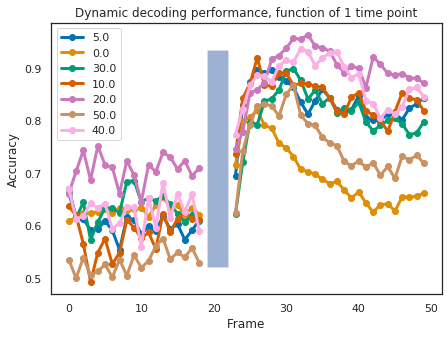

In [35]:
plt.rcParams['figure.figsize'] = (7, 5)
ax_acc = plt.subplot(111)

color_dict_stand = {}
for ii, x in enumerate(plt.rcParams['axes.prop_cycle']()):
    color_dict_stand[ii] = x['color']
    if ii > 8:
        break
        
def plot_interrupted_trace(ax, plot_array, llabel='', linest='-', ccolor='grey'):
    breakpoint = sessions[0].art_gap_start
    time_1 = sessions[0].filter_ps_array[:breakpoint]
    time_2 = sessions[0].filter_ps_array[breakpoint:]
    
    ax_acc.plot(time_1, plot_array[:breakpoint], '.-', linewidth=3, linestyle=linest, markersize=12, color=ccolor, label=llabel)
    ax_acc.plot(time_2, plot_array[breakpoint:], '.-', linewidth=3, linestyle=linest, markersize=12, color=ccolor)
    ax_acc.axvspan(xmin=time_1[-1] + 1, xmax=time_2[0] - 1, ymin=0.1, ymax=0.9, alpha=0.1)
    return ax_acc

# plot_interrupted_trace(ax=ax_acc, plot_array=lick_acc, llabel='decision', ccolor=(0.00784313725490196, 0.6196078431372549, 0.45098039215686275))
# plot_interrupted_trace(ax=ax_acc, plot_array=ps_acc, llabel='ps', ccolor=(0.5803921568627451, 0.5803921568627451, 0.5803921568627451))

iplot = 0
for istim, acc_part in lick_acc_split.items():
    plot_interrupted_trace(ax=ax_acc, plot_array=acc_part, llabel=str(istim), ccolor=color_dict_stand[iplot])
    iplot += 1

ax_acc.set_xlabel('Frame'); ax_acc.set_ylabel('Accuracy')
ax_acc.legend(); ax_acc.set_title('Dynamic decoding performance, function of 1 time point');
# plt.xlim([180, 220])

## ideas to improve / directions to go

#### Current plot:

- Quantify statistical significance between go/no go 
- S1 vs S2
- Distribution weight matrix
- plot \Delta W(t, t-1)

#### Try to find a function of the data that enhances the readout.

- Dimensionality reduction (dPCA should be ideal, theoretically)

- different integration of time points per neuron? (i.e. separate, some other function etc)

- Try to find something that relates PS decoding to licking decoding

#### S1 / S2 comparison

- Add dynamic prediction between populations -> subspaces -> Same question as with semedo data (i.e. different neurons that predict S2 or decode stim)

- We don't really find a difference between S1/S2 performance (-> large population?)

- Use increasing/decreasing number of neurons